# HatLab Parameters
Generating Fidelity Landscapes using the HatLab experimental parameters.

$\alpha = 4.54 \, \text{GHz}$

$\delta = -190 \, \text{MHz}$

We turn $\delta$ and $\alpha$ from frequencies to angular frequencies. Additionally, our amplitude is now also angular.

In [1]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip

import system.theoretical2pi as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen
importlib.reload(pulse_gen)
import utils.expectation_values as expect
importlib.reload(expect)

pass

In [4]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm
all_results = []
_amp = 2.5 * 2 * np.pi
_off = 0
_dur = 35

In [5]:
def run_once(dur):
    tlist = np.linspace(0, dur, int(dur*2))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=0.2, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "frequency":  system.first_energy_spacing/3 - _off,
        "duration": dur,
        "amplitude": _amp
    }

In [24]:
iterations = 150
for i in tqdm(range(0, iterations)):
    _off = np.linspace(0.0001, 0.05, iterations)[i]
    already_did_this_offset = False
    for result in all_results:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    all_results += parallel_map(run_once, np.linspace(10, 2000, 50)) # , progress_bar=True

100%|██████████| 150/150 [1:30:18<00:00, 36.13s/it]


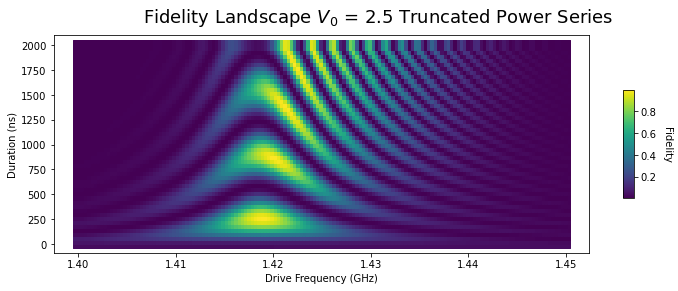

In [34]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
freqs = []
all_results_to_graph = copy.deepcopy(all_results)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
    offs.append(result["offset"])
    durs.append(result["duration"])
    fids.append(result["fidelity"])
    result["frequency"] = system.first_energy_spacing/3 - result["offset"]
    freqs.append(result["frequency"])


fig, axs = plt.subplots(figsize=(12, 4))
fig.suptitle("Fidelity Landscape $V_0$ = %.1f Truncated Power Series" % amps[-1], fontsize=18)
axs.set_xlabel("Drive Frequency (GHz)")
axs.set_ylabel("Duration (ns)")
surf = axs.scatter(freqs, durs, c=fids, cmap=None, marker="s", s=100)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("Fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)

In [50]:
print(system.energies[0] - system.energies[1])
print(system.energies[1] - system.energies[2])
print(system.energies[2] - system.energies[3])
print(system.energies[3] - system.energies[4])

-4.3410027783501475
-4.128774455947212
-3.881222186023318
-2.7354807742090594


In [35]:
import utils.saver as saver

saver.save(all_results, "theoretical_landscape_2-5_truncated_no2pi")

# Try Full Cosine

In [40]:
import system.theoreticalReverted as system # change system to full cosine system we reverted back to
importlib.reload(system)

<module 'system.theoreticalReverted' from '../system/theoreticalReverted.py'>

In [41]:
all_results2 = []

In [42]:
iterations = 150
for i in tqdm(range(0, iterations)):
    _off = np.linspace(0.0001, 0.05, iterations)[i]
    already_did_this_offset = False
    for result in all_results2:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    all_results2 += parallel_map(run_once, np.linspace(10, 2000, 50)) # , progress_bar=True

100%|██████████| 150/150 [57:49<00:00, 23.13s/it]


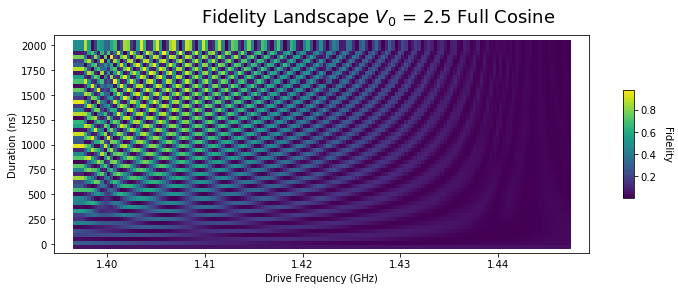

In [45]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
freqs = []
all_results_to_graph = copy.deepcopy(all_results2)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
    offs.append(result["offset"])
    durs.append(result["duration"])
    fids.append(result["fidelity"])
    result["frequency"] = system.first_energy_spacing/3 - result["offset"]
    freqs.append(result["frequency"])


fig, axs = plt.subplots(figsize=(12, 4))
fig.suptitle("Fidelity Landscape $V_0$ = %.1f Full Cosine" % amps[-1], fontsize=18)
axs.set_xlabel("Drive Frequency (GHz)")
axs.set_ylabel("Duration (ns)")
surf = axs.scatter(freqs, durs, c=fids, cmap=None, marker="s", s=100)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("Fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)

In [44]:
import utils.saver as saver

saver.save(all_results2, "theoretical_landscape_2-5_fullcosine_no2pi")

# Animate Through Amplitudes

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation

# meta_offs = [offs at V=2.5, offs at V=2.6, etc...]

fig = plt.figure()

points = plt.scatter([],[], s=100)

def init():
    return points

def animate(i):
    #swap to next graph
    points = plt.scatter(meta_offs[i], meta_durs[i], c=meta_fids[i], marker="s", s=100)

    return points #return everything that must be updated

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

plt.show()